## K-Means Clustering with NLTK Using TF-IDF Vectors

If we have a bunch of documents, we might want to try some methods to group them into similar groups even if we don't know what's in them.

Using TF-IDF is a start to this process, usually.  We take the vectors of scores from TF-IDF as input to the clustering.

Note: this code is largely based on Brandon Rose's excellent notebook at http://brandonrose.org/clustering

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nltk
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

import nlp_utilities as nlp  # this is our utility code file with new stuff

Let's load in some texts.  We'll use the 1945 onwards SOTU speeches.

In [2]:
filenames = nlp.get_filenames("data/jobs/mix_jobs/")

In [3]:
filenames

['data/jobs/mix_jobs/bi_595b4cf69edd5213dc82318c.txt',
 'data/jobs/mix_jobs/bi_595b4cf69edd5213dc82318f.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85df.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e3.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e4.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e5.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e6.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e8.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e9.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85eb.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85ed.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85ef.txt',
 'data/jobs/mix_jobs/bi_595c9e069edd522ba07c85f0.txt',
 'data/jobs/mix_jobs/bi_595c9e069edd522ba07c85f1.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823173.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823175.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823178.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823179.txt',
 'data

In [4]:
texts = nlp.load_texts_as_string(filenames)

**Texts** is a dictionary, with the keys being the filenames and the values being the text.  To read the values or keys as a list, you have to wrap it in a list() operator:

In [5]:
list(texts.keys())[0:20]

['data/jobs/mix_jobs/bi_595c9e059edd522ba07c85ef.txt',
 'data/jobs/mix_jobs/mark_595b4c5f9edd5213dc823149.txt',
 'data/jobs/mix_jobs/fin_595b4cc79edd5213dc823185.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc82316d.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823179.txt',
 'data/jobs/mix_jobs/mark_595b4c5f9edd5213dc823151.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc82316e.txt',
 'data/jobs/mix_jobs/mark_595b4c5f9edd5213dc82314a.txt',
 'data/jobs/mix_jobs/bi_595b4cf69edd5213dc82318c.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc82316b.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc82317b.txt',
 'data/jobs/mix_jobs/bi_595c9e059edd522ba07c85e6.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc82315c.txt',
 'data/jobs/mix_jobs/mark_595b4c5f9edd5213dc823146.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc823161.txt',
 'data/jobs/mix_jobs/fin_595b4cc69edd5213dc823173.txt',
 'data/jobs/mix_jobs/mark_595b4c5f9edd5213dc82314e.txt',
 'data/jobs/mix_jobs/web_595b4c8e9edd5213dc823

In [40]:
# We will need this in the future.  You'll see when we list cluster center words.

mystops = ["e", "l", "nos", "vos", "ou", "est"]

# first time thru, run it without any custom stops and check your results.

#mystops = []

We're going to use a function from scikit-learn to make the TF-IDF vectors we need. We'll use a function in the nlp_utilities.py file to tokenize and clean the tokens, an option we can pass into the vectorizer:

In [30]:
TfidfVectorizer?

Some of these switches control how many words to use. Features are the words, df is document
frequency.  If we eliminate very frequent words we eliminate stopwords, and too infrequent eliminates
overly specialized vocabulary.

In [41]:
# first we initialize it with settings:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.2, tokenizer=nlp.tokenize_clean, stop_words=mystops)

# this applies the vectorizer we defined to the texts!
tfidf_matrix = tfidf_vectorizer.fit_transform(texts.values()) #fit the vectorizer to synopses

print(tfidf_matrix.shape) # this is the size of the array of features.

(58, 155)


In [42]:
# this is the vocabulary from our tokenizing.
terms = tfidf_vectorizer.get_feature_names()

In [43]:
# this looks pretty bad.  We can clean it later if we need to, if it
# affects how we cluster.

terms[0:10]

['actions',
 'activités',
 'afin',
 'ainsi',
 'analyse',
 'analyses',
 'anglais',
 'ans',
 'assurer',
 'auprès']

## K-Means Clustering

One of the unsupervised exploratory methods of data analysis is called clustering - in which similar items are grouped together by statistical processes. K-means is one of the most well-known. It works by randomly positioning "centers" for data points, depending on how many centers you ask for, and repeatedly moving the centers and cluster assignment until it "converges" on a stable solution.

We can watch how it works here:

* http://tech.nitoyon.com/en/blog/2013/11/07/k-means/

* https://www.naftaliharris.com/blog/visualizing-k-means-clustering/



In [44]:
from sklearn.cluster import KMeans

num_clusters = 4  # this is a number you can change.

# initialize with settings:
km = KMeans(n_clusters=num_clusters)

# apply it to our data, which is tf-idf scores for all the words/docs
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [45]:
# we can look at the options this way in the notebook.
KMeans?

In [36]:
# Clusters is a number showing which text is in which cluster, from 0 to 3
clusters[0:10]

[1, 1, 3, 1, 1, 2, 1, 2, 0, 0]

In [46]:
# a useful function to clean filenames for labels/printing.
def clean_filename(path):
    # Makes labels that are just the root filename minus .txt
    import os
    return os.path.basename(path).strip(".txt")

**Note:** To be able to run this next cell (especially for your homework), you must have defined a lot of variables using the code preceding.

Run the cells above if you haven't or if you get an error saying something is not defined.

In [47]:
# How to show the cluster results and words.  Your results may require you 
# to go back and clean out some custom stop words.

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for cluster in range(num_clusters):
    print("Cluster %d words:" % cluster, end='')
    
    for ind in order_centroids[cluster, :10]: # up to how many words per cluster
        print(terms[ind], end=',')
    print() # whitespace row
    print()
    
    print("Cluster %d documents:" % cluster, end='')
    
    # enumerate produces a pair of (index number, value) for the list.
    for item, filename in enumerate(list(texts.keys())):
        if clusters[item] == cluster:
            print(' %s,' % clean_filename(filename), end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:
Cluster 0 words:votre,direction,gestion,performance,ans,business,nous,ce,notre,que,

Cluster 0 documents: mark_595b4c5f9edd5213dc823149, bi_595b4cf69edd5213dc82318c, web_595b4c8e9edd5213dc82316b, bi_595c9e059edd522ba07c85e6, fin_595b4cc79edd5213dc823180, fin_595b4cc79edd5213dc82318b, bi_595c9e059edd522ba07c85e5, fin_595b4cc79edd5213dc82317f, bi_595c9e059edd522ba07c85e8, bi_595c9e059edd522ba07c85df,

Cluster 1 words:business,groupe,france,intelligence,niveau,ses,votre,plus,domaines,personnes,

Cluster 1 documents: bi_595c9e059edd522ba07c85ef, fin_595b4cc79edd5213dc823185, web_595b4c8e9edd5213dc82316e, fin_595b4cc69edd5213dc823173, bi_595c9e059edd522ba07c85eb, web_595b4c8e9edd5213dc82315a, bi_595c9e059edd522ba07c85e4, bi_595c9e059edd522ba07c85e3, fin_595b4cc79edd5213dc823186, bi_595c9e069edd522ba07c85f1, bi_595b4cf69edd5213dc82318f, bi_595c9e069edd522ba07c85f0,

Cluster 2 words:gestion,web,site,communication,groupe,projets,notre,aux,poste,sein,

Cluster 2 documents

At this point, you probably have some junk words in your centroid word lists.
 You can rerun the code above, adjusting to add stop words in the tokenization step.

## Graphing It (Optional)

There is a lot of advanced code in here. I borrowed it from Brandon's blog post referenced at the top of this notebook. I modified it only a bit.

You don't need to understand all of it, but should be able to run it.

The code below will need to be changed when you run your K-Means clustering, because your results will be different.  You need to look at the words in each cluster number and adjust them below:

In [48]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {1: 'intelligence', 
                 3: 'marketing', 
                 0: 'direction, gestion', 
                 2: 'web'}

We talk about cosine similarity and distance in the TF-IDF Hierarchical clustering notebook.

In [50]:
# This is a simple way to get the distance between the vectors. Will be needed for plotting them.

from sklearn.metrics.pairwise import cosine_similarity

# the distance is the opposite of the similarity. So we take 1 - similarity.
dist = 1 - cosine_similarity(tfidf_matrix)

Because we have many documents, many words, and many scores and measures... this is hard to graph in a simple picture. It's "multidimensional." But we can use a couple of techniques to try to reduce it to 2 dimensions for a plot. One is called multi-dimensional scaling, or MDS.  (The other common method is PCA, principal component analysis. We can uncomment and run that below.)

In [62]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

# convert two components as we're plotting points in a 2-dimensional plane
# "precomputed" because we provide a distance matrix as dissimilarity

mds = MDS(n_components=2, dissimilarity="precomputed")

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#### Convert this cell from markdown to code in order to try PCA instead.

from sklearn import decomposition

pca = decomposition.PCA(n_components=3)

pos = pca.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


In [63]:
def clean_filenames(paths):
    # Makes labels for dots that are just the root filename minus .txt
    import os
    return [os.path.basename(path).strip(".txt") for path in paths]

labels = clean_filenames(list(texts.keys()))

In [64]:
import pandas as pd

df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labels))

#group by cluster
groups = df.groupby('label')

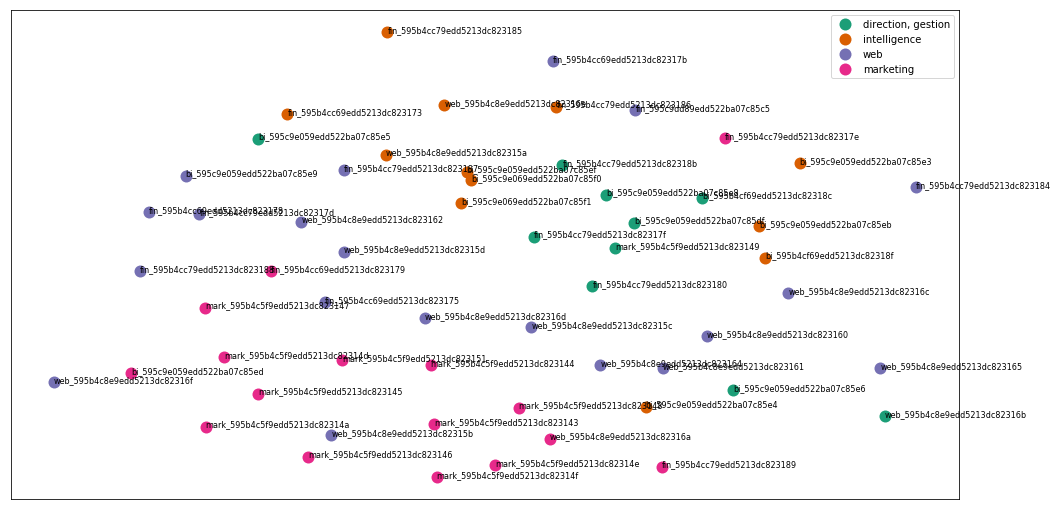

In [65]:
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

### A 3d plot sometimes helps, but not in many cases.  Also the labels take up a lot of room.

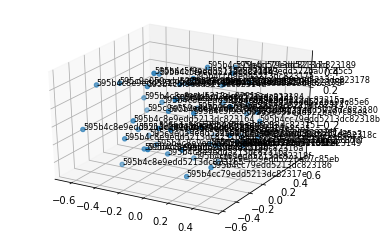

In [66]:
# 3D plot, from https://de.dariah.eu/tatom/working_with_text.html
# who said
# après Jeremy M. Stober, Tim Vieira
# https://github.com/timvieira/viz/blob/master/mds.py

def get_years(labels):
    return [label.split('_')[-1:][0] for label in labels]

mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

for x, y, z, s in zip(pos[:, 0], pos[:, 1], pos[:, 2], get_years(labels)):
    ax.text(x, y, z, s, size=8)

#ax.view_init(30, 90)
plt.show()

More relevant links:
* http://stackoverflow.com/questions/20176590/plot-the-centroid-values-over-the-existing-plot-using-matplotlib
* http://glowingpython.blogspot.jp/2012/04/k-means-clustering-with-scipy.html